In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
def data_preprocessing(data):
    #Prepare the dataset
    # Convert Open Time to datetime and extract useful features
    data = data.drop(columns=["Open Time", "Coin"]) 
    # Define features and target
    X = data.drop(columns=["Close"])
    y = data["Close"]
    
    return X, y

In [15]:
def scaling_train_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [16]:
def train_model(X_train_scaled, y_train):
    
    ## Train XGBoost model
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    return xgb_model

In [54]:

def randomized_search(X_train_scaled, X_test_scaled, y_train, y_test):
    # Define the XGBoost regressor
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

    # Define the parameter grid for randomized search
    param_dist = {
        'n_estimators': [50, 100, 200],  # Number of boosting rounds
        'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
        'max_depth': [3, 5, 7, 9],  # Maximum depth of trees
        'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight for child nodes
        'subsample': [0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for training each tree
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Fraction of features used for training each tree
        'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a further partition
        'reg_alpha': [0, 0.01, 0.1],  # L1 regularization
        'reg_lambda': [0, 0.1, 1.0]  # L2 regularization
    }

    # Create the RandomizedSearchCV instance
    randomized_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=10,  # Number of random parameter combinations to test
        cv=3,  # Number of folds for cross-validation
        scoring='neg_mean_squared_error',  # Scoring metric for regression
        verbose=1,  # Show detailed output
        n_jobs=-1,  # Use all CPU cores for faster computation
        random_state=42  # For reproducibility
    )

    # Fit the randomized search to the data
    randomized_search.fit(X_train_scaled, y_train)

    # Get the best parameters and the corresponding score
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score (neg_mean_squared_error): {best_score}")

    # Get the best estimator (model with the best parameters)
    best_model = randomized_search.best_estimator_

    # Now you can use this model for predictions on the test set
    predictions = best_model.predict(X_test_scaled)
    print(predictions)






In [17]:
def evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test, xgb_model, currency):
    y_pred = xgb_model.predict(X_test_scaled)
    # Evaluate model
    train_score = xgb_model.score(X_train_scaled, y_train)
    test_score = xgb_model.score(X_test_scaled, y_test)
    print(f"Train score for {currency}:" + str(train_score))
    print(f"Test score for {currency}:" + str(test_score))
    return y_pred
    

In [18]:
def plot_comparison(y_test, y_pred, currency):
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values[:100], label="Actual", linestyle="-", marker="o", alpha=0.7)  # First 100 points
    plt.plot(y_pred[:100], label="Predicted", linestyle="-", marker="x", alpha=0.7)

    plt.xlabel("Time (minutes)")
    plt.ylabel("Closing Price (USD)")
    plt.title(f"Actual vs. Predicted Closing Prices (First 100 Minutes of Training Dataset) - {currency}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
def next_minute_price(X,y, model,currency):
    # Predict the next minute's closing price
    next_minute_price = model.predict(X.iloc[-1].values.reshape(1, -1))[0]
    if next_minute_price > y.iloc[-1]:
        print(f"{currency}: The price will increase from ${y.iloc[-1]} to ${next_minute_price}")
    elif next_minute_price < y.iloc[-1]:
        print(f"{currency}: The price will decrease from ${y.iloc[-1]} to ${next_minute_price}")

##### 1. Training with Indicators (MACD & RSI)

In [21]:
# Load the datasets
btc_indicators = pd.read_csv("processed_data/BTC_1m_data_indicators.csv")
eth_indicators = pd.read_csv("processed_data/ETH_1m_data_indicators.csv")
xrp_indicators = pd.read_csv("processed_data/XRP_1m_data_indicators.csv")
solana_indicators = pd.read_csv("processed_data/SOL_1m_data_indicators.csv")


In [22]:
X_btc, y_btc = data_preprocessing(btc_indicators)
X_eth, y_eth = data_preprocessing(eth_indicators)
X_xrp, y_xrp = data_preprocessing(xrp_indicators)
X_sol, y_sol = data_preprocessing(solana_indicators)

In [23]:
# X_train and X_test are scaled 
X_train_btc, X_test_btc, y_train_btc, y_test_btc = scaling_train_test_split(X_btc, y_btc)
X_train_eth, X_test_eth, y_train_eth, y_test_eth = scaling_train_test_split(X_eth, y_eth)
X_train_xrp, X_test_xrp, y_train_xrp, y_test_xrp = scaling_train_test_split(X_xrp, y_xrp)
X_train_sol, X_test_sol, y_train_sol, y_test_sol = scaling_train_test_split(X_sol, y_sol)

In [24]:
btc_model= train_model(X_train_btc, y_train_btc)
eth_model = train_model(X_train_eth, y_train_eth)
xrp_model = train_model(X_train_xrp, y_train_xrp)
solana_model = train_model(X_train_sol, y_train_sol)

In [25]:
y_pred_btc = evaluate_model(X_train_btc, X_test_btc, y_train_btc, y_test_btc, btc_model,'BTC')
y_pred_eth = evaluate_model(X_train_eth, X_test_eth, y_train_eth, y_test_eth, eth_model, 'ETH')
y_pred_xrp = evaluate_model(X_train_xrp, X_test_xrp, y_train_xrp, y_test_xrp, xrp_model, 'XRP')
y_pred_sol = evaluate_model(X_train_sol, X_test_sol, y_train_sol, y_test_sol, solana_model, 'SOL')

Train score for BTC:0.9999038273936711
Test score for BTC:0.9386306479748676
Train score for ETH:0.9999432087964238
Test score for ETH:0.9533356046347241
Train score for XRP:0.9999508429209685
Test score for XRP:0.9989286196989684
Train score for SOL:0.9999168199745362
Test score for SOL:0.4139705959700549


In [53]:
# BTC best metrics using GridSearchCV 
randomized_search(X_train_btc, X_test_btc, y_train_btc, y_test_btc)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Score (neg_mean_squared_error): -105441.7970496003
[97085.97 97086.94 97086.94 ... 91189.46 91190.84 91186.86]


In [26]:
next_minute_price(X_btc, y_btc, btc_model, 'BTC')
next_minute_price(X_eth, y_eth, eth_model, 'ETH')
next_minute_price(X_xrp, y_xrp, xrp_model, 'XRP')
next_minute_price(X_sol, y_sol, solana_model, 'SOL')

BTC: The price will increase from $87246.0 to $109088.796875
ETH: The price will increase from $2413.3 to $3696.033203125
XRP: The price will increase from $2.2132 to $3.3665859699249268
SOL: The price will increase from $139.27 to $288.7169189453125


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

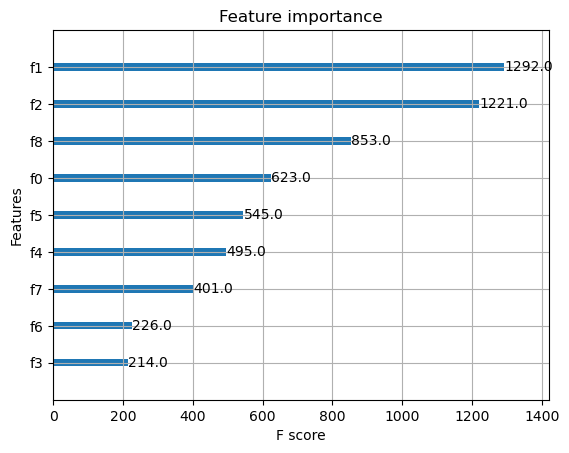

In [27]:
xgb.plot_importance(btc_model)

Feature 1 (Highest Price) looks like it has the highest importance here.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

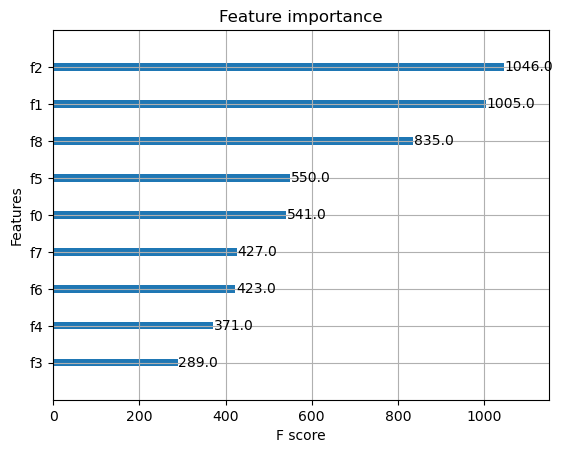

In [32]:
xgb.plot_importance(eth_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

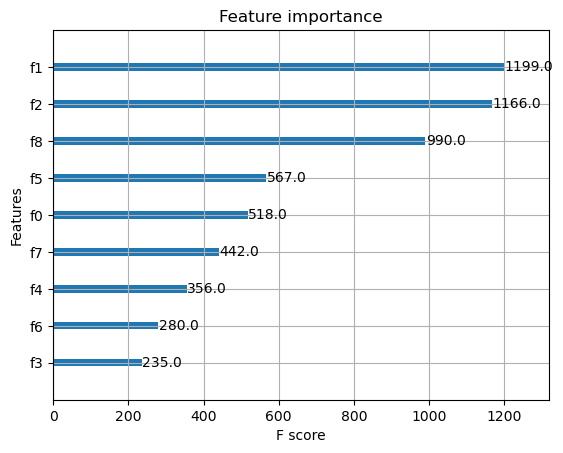

In [33]:
xgb.plot_importance(xrp_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

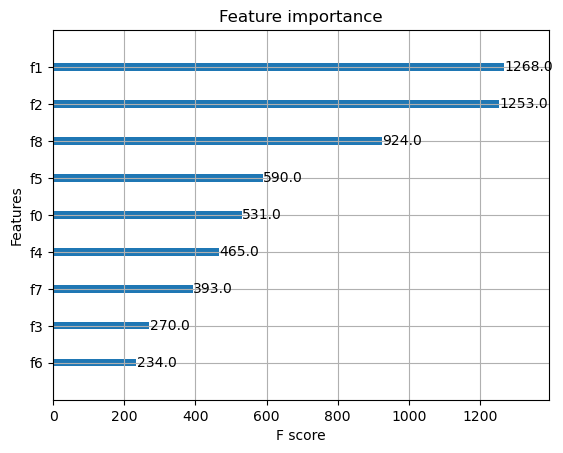

In [34]:
xgb.plot_importance(solana_model)

##### Comparing Actual Prices against Model Predictions

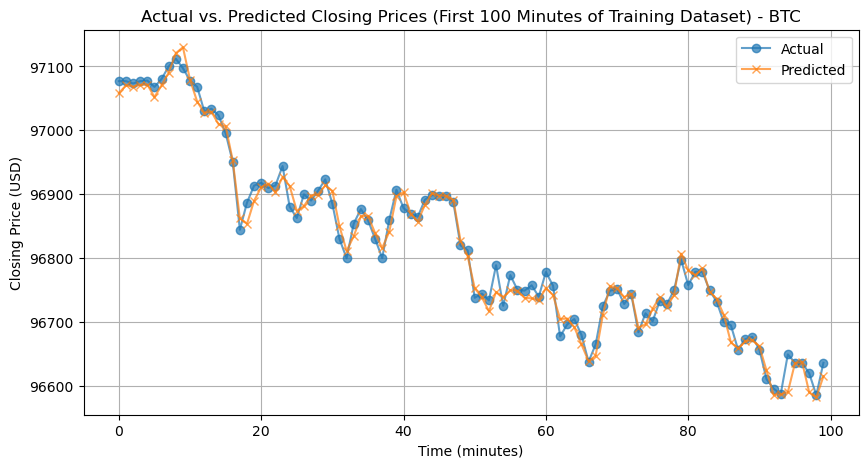

In [28]:
plot_comparison(y_test_btc, y_pred_btc, 'BTC')

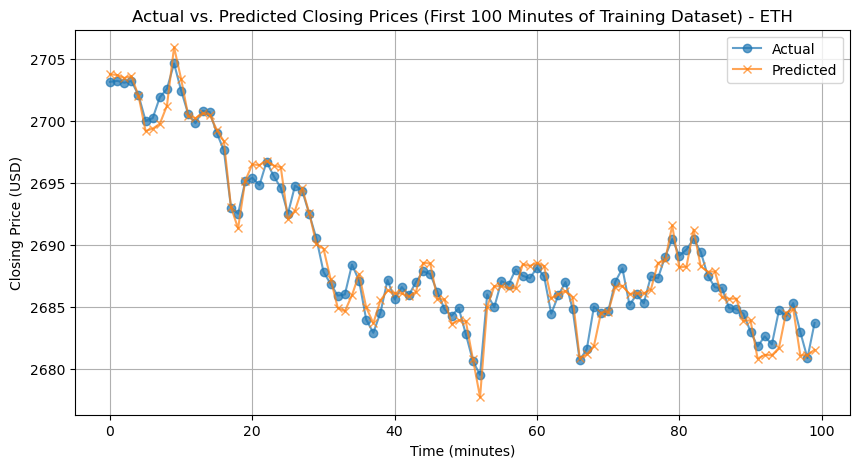

In [29]:
plot_comparison(y_test_eth, y_pred_eth, 'ETH')

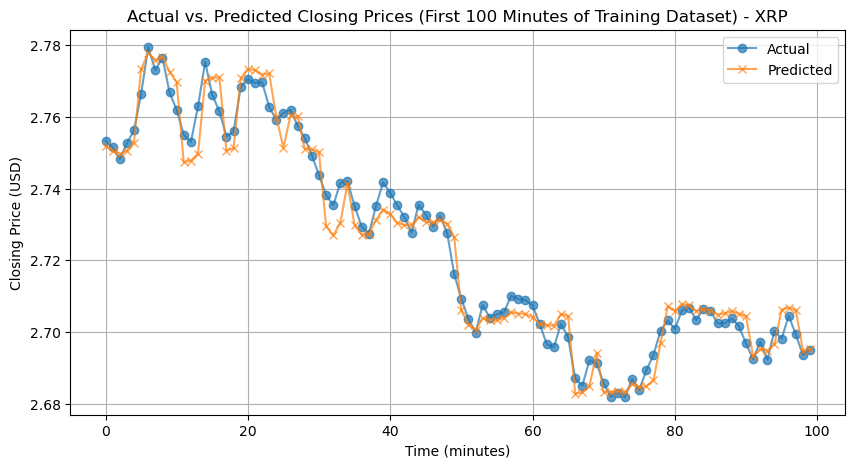

In [30]:
plot_comparison(y_test_xrp, y_pred_xrp, 'XRP')

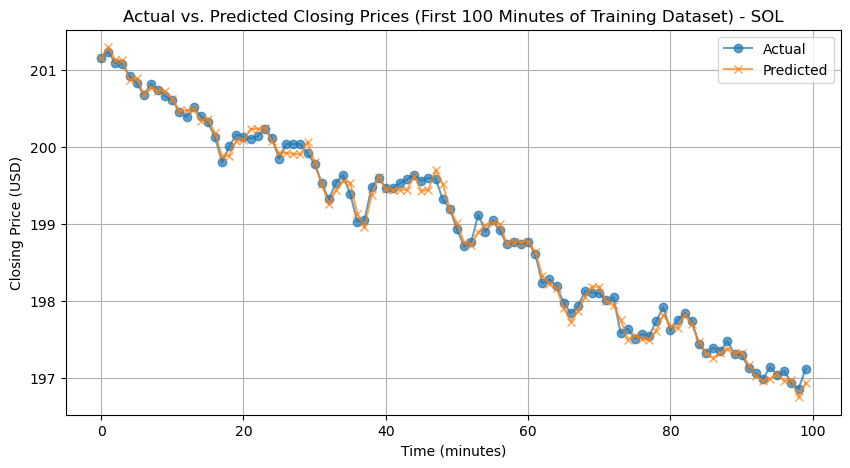

In [31]:
plot_comparison(y_test_sol, y_pred_sol, 'SOL')

#### 2. Training using only prices data (no indicators)

In [36]:
# Load the datasets
btc_indicators_2 = pd.read_csv("market_data/BTC_1m_data.csv")
eth_indicators_2 = pd.read_csv("market_data/ETH_1m_data.csv")
xrp_indicators_2 = pd.read_csv("market_data/XRP_1m_data.csv")
solana_indicators_2 = pd.read_csv("market_data/SOL_1m_data.csv")


In [37]:
X_btc_2, y_btc_2 = data_preprocessing(btc_indicators_2)
X_eth_2, y_eth_2 = data_preprocessing(eth_indicators_2)
X_xrp_2, y_xrp_2 = data_preprocessing(xrp_indicators_2)
X_sol_2, y_sol_2 = data_preprocessing(solana_indicators_2)

In [39]:
# X_train and X_test are scaled 
X_train_btc_2, X_test_btc_2, y_train_btc_2, y_test_btc_2 = scaling_train_test_split(X_btc_2, y_btc_2)
X_train_eth_2, X_test_eth_2, y_train_eth_2, y_test_eth_2 = scaling_train_test_split(X_eth_2, y_eth_2)
X_train_xrp_2, X_test_xrp_2, y_train_xrp_2, y_test_xrp_2 = scaling_train_test_split(X_xrp_2, y_xrp_2)
X_train_sol_2, X_test_sol_2, y_train_sol_2, y_test_sol_2 = scaling_train_test_split(X_sol_2, y_sol_2)

In [40]:
btc_model_2= train_model(X_train_btc_2, y_train_btc_2)
eth_model_2 = train_model(X_train_eth_2, y_train_eth_2)
xrp_model_2 = train_model(X_train_xrp_2, y_train_xrp_2)
solana_model_2 = train_model(X_train_sol_2, y_train_sol_2)

In [41]:
y_pred_btc_2 = evaluate_model(X_train_btc_2, X_test_btc_2, y_train_btc_2, y_test_btc_2, btc_model_2,'BTC')
y_pred_eth_2 = evaluate_model(X_train_eth_2, X_test_eth_2, y_train_eth_2, y_test_eth_2, eth_model_2, 'ETH')
y_pred_xrp_2 = evaluate_model(X_train_xrp_2, X_test_xrp_2, y_train_xrp_2, y_test_xrp_2, xrp_model_2, 'XRP')
y_pred_sol_2 = evaluate_model(X_train_sol_2, X_test_sol_2, y_train_sol_2, y_test_sol_2, solana_model_2, 'SOL')

Train score for BTC:0.9998486636204502
Test score for BTC:0.5820175582182098
Train score for ETH:0.9998933894403679
Test score for ETH:0.6968721386160612
Train score for XRP:0.9999312598954743
Test score for XRP:0.9958790828209381
Train score for SOL:0.9997881552022033
Test score for SOL:-0.7416273612771496


In [42]:
next_minute_price(X_btc_2, y_btc_2, btc_model_2, 'BTC')
next_minute_price(X_eth_2, y_eth_2, eth_model_2, 'ETH')
next_minute_price(X_xrp_2, y_xrp_2, xrp_model_2, 'XRP')
next_minute_price(X_sol_2, y_sol_2, solana_model_2, 'SOL')

BTC: The price will increase from $83940.96 to $108808.890625
ETH: The price will increase from $2222.31 to $3711.072265625
XRP: The price will increase from $2.145 to $3.359358072280884
SOL: The price will increase from $145.44 to $284.90594482421875


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

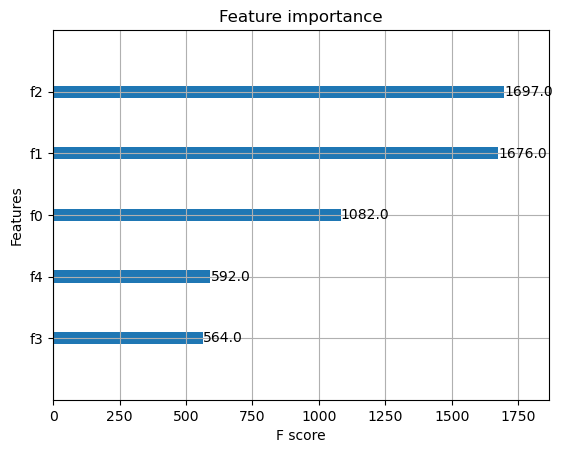

In [43]:
xgb.plot_importance(btc_model_2)

Feature 1 (Highest Price) looks like it has the highest importance here.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

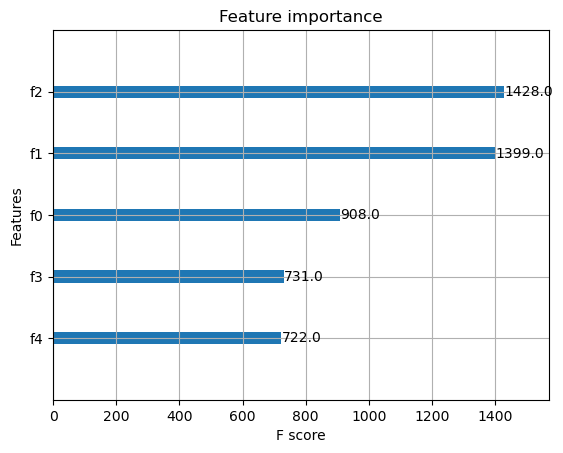

In [44]:
xgb.plot_importance(eth_model_2)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

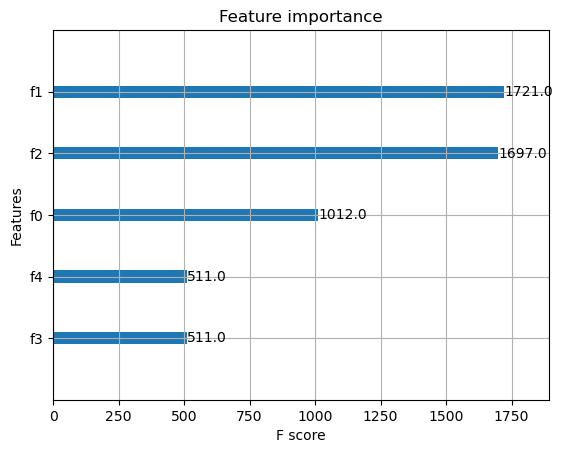

In [45]:
xgb.plot_importance(xrp_model_2)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

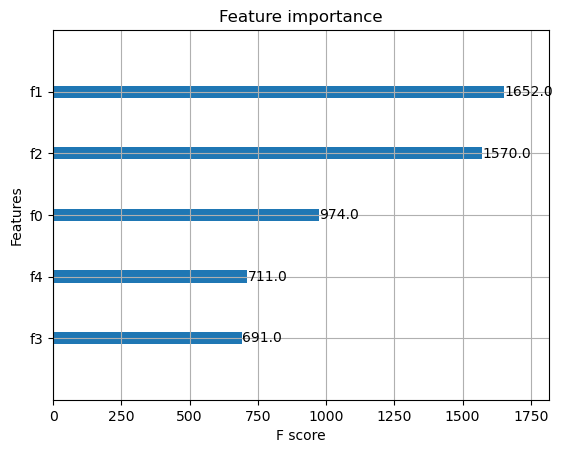

In [46]:
xgb.plot_importance(solana_model_2)

##### Comparing Actual Prices against Model Predictions

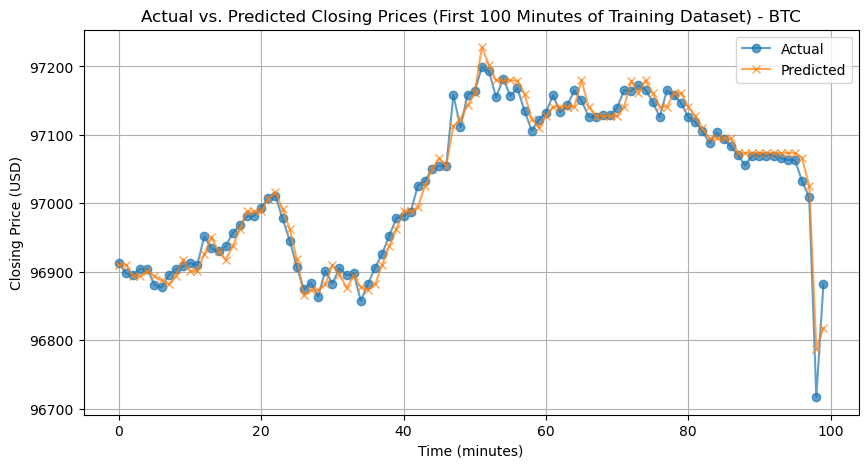

In [47]:
plot_comparison(y_test_btc_2, y_pred_btc_2, 'BTC')

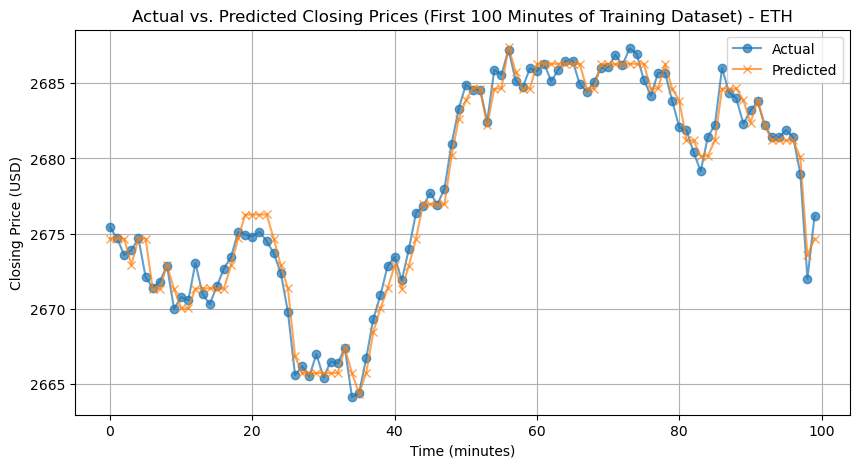

In [48]:
plot_comparison(y_test_eth_2, y_pred_eth_2, 'ETH')

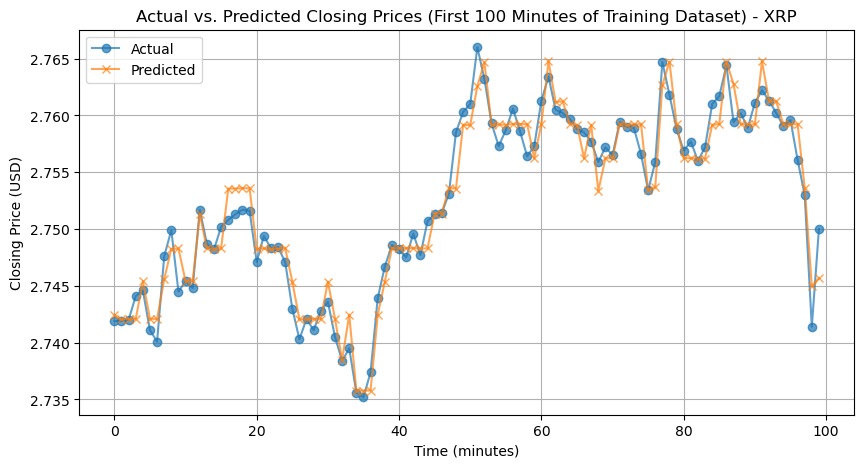

In [49]:
plot_comparison(y_test_xrp_2, y_pred_xrp_2, 'XRP')

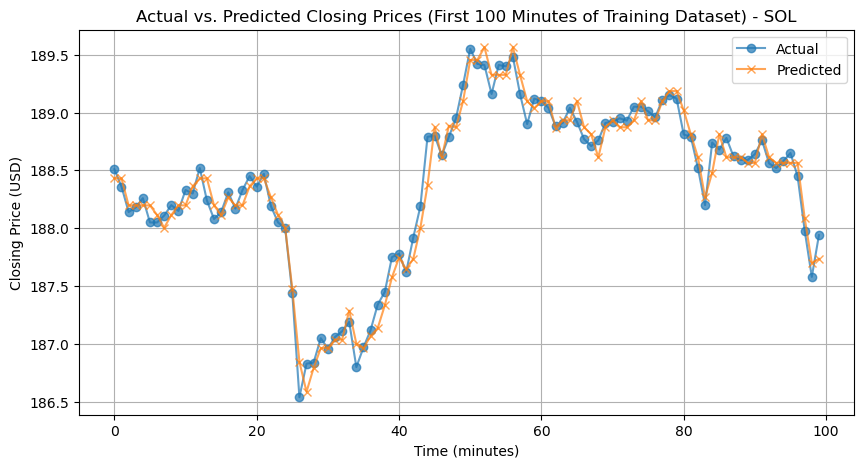

In [50]:
plot_comparison(y_test_sol_2, y_pred_sol_2, 'SOL')